# Fitting radial profiles to galaxies

### Isaac Cheng - October 2021

Read Section 4.5 ("CO Radial Profiles") of the VERTICO paper and also look at Table 1. Can
calculate eccentricity of ellipse from position angle + inclination. Also take a look at
[`photutils.aperture.EllipticalAnnulus`](https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAnnulus.html)
and [this tutorial](https://photutils.readthedocs.io/en/stable/aperture.html).
Fit annuli starting from the centre, moving outward. The semiminor axis should be at least
the beam width for the VERTICO data. Results should be similar to Figure 9 of the VERTICO
paper.


In [1]:
# May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"
# 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import astropy.units as u
import astropy.coordinates as coord
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import fits_plot_utils as utils
from photutils.aperture import aperture_photometry, EllipticalAnnulus, EllipticalAperture, BoundingBox
import dill
from radio_beam import Beam
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.patches import Ellipse
import copy

/arc/home/IsaacCheng/coop_f2021/warmup


# Functions


In [51]:
# TODO: make a function that find the ellipse enclosing x% of the data

def calc_eccentricity(inclination):
    """
    Calculates the eccentricities of galaxies given their inclinations. Assumes galaxies
    are perfectly circular disks (reasonable for spiral galaxies, not necessarily true for
    other morphologies).
    
    The inclination of a galaxy, i, is defined as the ratio of its observed (semi-)minor
    axis, b, to its observed (semi-)major axis, a:
                                    cos(i) := b/a
    Thus, the eccentricity, e, of a galaxy can be directly calculated from its
    inclination:
                        e := sqrt(1 - (b/a)^2) = sqrt(1 - cos^2(i))
    
    Parameters:
      inclination :: float or array-like
        The inclinations of the galaxies in degrees
    
    Returns: eccentricity
      eccentricity :: float or array-like
        The eccentricities of the galaxies
    """
    cosi = np.cos(np.deg2rad(inclination))
    return np.sqrt(1 - cosi * cosi)


# def calc_tot_sn_annulus(signal, annulus, noise=None, include_bad=True, phot_kwargs=None):
#     """
#     ! OLD METHOD. DO NOT USE !
#     Calculates total signal (and optionally noise) of data enclosed in an annulus. Only
#     works with one annulus per function call (because of aperture_photometry() keywords).

#     TODO: finish docstring

#     Parameters:
#       include_bad :: bool (optional)
#         If True, includes NaNs and infs in signal & noise arrays by setting these values
#         to zero. If False, exclude NaNs and infs entirely from calculation.

#     Returns: tot_signal, tot_noise
#       tot_signal :: float
#         The total signal of the data in the annulus. This is a straight arithmetic sum.
#       tot_noise :: float or None
#         If noise is not None, this is the total noise of the data in the annulus. Unlike
#         the total signal, the total noise is summed in quadrature. If noise is None, this
#         return value is also None.
#     """
#     if noise is not None:
#         mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
#     else:
#         mask = ~np.isfinite(signal)
#     if include_bad:
#         # Set non-detections and bad pixels to zero
#         signal = np.ma.masked_array(signal, mask=mask).filled(fill_value=0.0)
#         if noise is not None:
#             noise = np.ma.masked_array(noise, mask=mask).filled(fill_value=0.0)
#         aper_mask = None  # include all pixels
#     else:
#         # Skip non-detections and bad pixels from summation
#         aper_mask = mask
#     #
#     # Method 1
#     #
#     # ann_mask = annulus.to_mask(method="exact")
#     # tot_signal = ann_mask.multiply(signal)
#     # tot_signal = np.nansum(tot_signal)
#     # if noise is not None:
#     #     # Add noise in quadrature
#     #     tot_noise = ann_mask.multiply(noise * noise)
#     #     tot_noise = np.nansum(tot_noise)
#     #     tot_noise = np.sqrt(tot_noise)
#     # else:
#     #     tot_noise = None
#     # return tot_signal, tot_noise
#     #
#     # Method 2
#     #
#     if phot_kwargs is None:
#         phot_results = aperture_photometry(signal, annulus, error=noise, mask=aper_mask)
#     else:
#         phot_results = aperture_photometry(
#             signal, annulus, error=noise, mask=aper_mask, **phot_kwargs
#         )
#     if noise is not None:
#         return (
#             float(phot_results["aperture_sum"].value),
#             float(phot_results["aperture_sum_err"].value),
#         )
#     else:
#         return (float(phot_results["aperture_sum"].value), None)


def calc_avg_sn_aperture(
    signal, aper, noise=None, include_bad=True, func="median", method="exact", plot=False,
):
    """
    Calculates average signal (and optionally noise) of data enclosed in an annulus,
    ellipse, or some other aperture shape supported by `photutils.aperture.PixelAperture`.
    Only works with one aperture per function call.
    
    If the extent of the aperture is larger than the signal or noise arrays, this function
    will automatically pad relevant arrays to ensure the mean/median is calculated
    correctly.
    
    Parameters:
      signal :: 2D array
        The signal array
      aper :: `photutils.aperture.PixelAperture` object
        The aperture over which to calculate the average quantities
      noise :: 2D array (optional)
        The noise (uncertainty) associated with the signal. Must have the same shape as
        the signal array
      include_bad :: bool (optional)
        If True, includes NaNs and infs in signal & noise arrays by setting these values
        to zero. If False, exclude NaNs and infs entirely from all calculations.
      func :: "median" or "mean" (optional)
        Specifies which "average" function to use: median or arithmetic mean
      method :: "exact" or "center" or "subpixel" (optional)
        The `photutils.aperture.aperture_photometry` method used to create the aperture
        masks
      plot :: bool (optional)
        If True, plots intermediate steps of the calculation (i.e., aperture, masked
        signal, and if calculating the mean, the area over which the mean is calculated)
    
    Returns: tot_signal, tot_noise
      avg_signal :: float
        The average (either median or arithmetic mean) signal of the data in the aperture
      avg_noise :: float or None
        If noise is not None, this is the average noise of the data in the aperture. If
        func=="mean", the noise is summed in quadrature and divided by the area of the
        aperture to get the average noise. If func=="median", the average noise is the
        median noise.
        If noise is None, this return value is also None.
    """

    def _debug_plot(arr, title=None):
        fig, ax = plt.subplots()
        img = ax.imshow(arr, origin="lower")
        fig.colorbar(img)
        ax.set_title(title) if title is not None else None
        plt.show()

    #
    # Check inputs and create masks
    #
    if aper.positions[0] > signal.shape[0] or aper.positions[1] > signal.shape[1]:
        print("WARNING: Centre of aperture is not within extent of signal array!")
    fill_value = 0.0 if include_bad else np.nan
    if noise is not None:
        if np.shape(noise) != np.shape(signal):
            raise ValueError("signal and noise arrays must have the same shape!")
        mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
    else:
        mask = ~np.isfinite(signal)
    #
    # Set non-detections and bad pixels to zero or NaN
    #
    signal = np.ma.masked_array(signal, mask=mask).filled(fill_value)
    if noise is not None:
        noise = np.ma.masked_array(noise, mask=mask).filled(fill_value)
    #
    # Pad arrays to wholly enclose aperture if necessary
    #
    signal_bbox = BoundingBox(
        ixmin=0, iymin=0, ixmax=signal.shape[1], iymax=signal.shape[0]
    )
    union_bbox = signal_bbox.union(aper.bbox)
    pad_amount = (
        (union_bbox.iymax - signal_bbox.iymax, signal_bbox.iymin - union_bbox.iymin),
        (signal_bbox.ixmin - union_bbox.ixmin, union_bbox.ixmax - signal_bbox.ixmax),
    )
    signal = np.pad(signal, pad_amount, mode="constant", constant_values=fill_value)
    if noise is not None:
        noise = np.pad(noise, pad_amount, mode="constant", constant_values=fill_value)
    # Modify centre of aperture if necessary
    aper = copy.deepcopy(aper)
    aper.positions[0] = aper.positions[0] - union_bbox.ixmin
    aper.positions[1] = aper.positions[1] - union_bbox.iymin
    #
    # Create mask
    #
    aper_mask = aper.to_mask(method=method)
    aper_mask = aper_mask.to_image(signal.shape)
    aper_mask = np.ma.masked_where(aper_mask <= 1e-12, aper_mask).filled(np.nan)
    if plot:
        _debug_plot(aper_mask, title="Mask")
    #
    # Calculate averages
    #
    masked_signal = signal * aper_mask
    if plot:
        _debug_plot(masked_signal, title="Masked signal")
    if func == "median":
        func = np.nanmedian
        avg_signal = func(masked_signal)
        if noise is not None:
            masked_noise = noise * aper_mask
            avg_noise = func(masked_noise)
    elif func == "mean":
        func = np.nansum
        # Straight arithmetic sum divided by area
        avg_signal = func(masked_signal)
        signal_area = np.copy(masked_signal)
        signal_area[~np.isnan(signal_area)] = 1.0
        avg_signal = avg_signal / np.nansum(signal_area * aper_mask)
        if plot:
            _debug_plot(signal_area * aper_mask, title="Dividing signal by this area")
        if noise is not None:
            # Add noise in quadrature then divide by area
            masked_noise = noise * noise * aper_mask
            avg_noise = func(masked_noise)
            noise_area = np.copy(masked_noise)
            noise_area[~np.isnan(noise_area)] = 1.0
            avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area * aper_mask)
            if plot:
                _debug_plot(noise_area * aper_mask, title="Dividing noise by this area")
    else:
        raise ValueError("func must be 'median' or 'mean'")
    if noise is None:
        avg_noise = None
    return avg_signal, avg_noise


def fit_annuli(
    center,
    i,
    pa,
    min_width,
    min_width_ax="minor",
    wcs=None,
    n_annuli=None,
    snr_cutoff=None,
    data=None,
    noise=None,
    max_snr_annuli=50,
    **kwargs,
):
    """
    Fits and creates `photutils.aperture.EllipticalAnnulus` (annulus) and
    `photutils.aperture.EllipticalAperture` (ellipse) objects given the user's criteria.
    The user must specify exactly one of: n_annuli or snr_cutoff.
    
    If creating more than one object (i.e., explicitly through the n_annuli parameter or 
    implicitly through the snr_cutoff parameter), the first (central) object will be an
    ellipse and the rest will be annuli that share the same centre, inclination, and
    position angle as the central ellipse.
    
    Note that if snr_cutoff is specified, the input data and noise must also be provided
    and these 2D arrays should be background-subtracted.
    
    Parameters:
      center :: 2-tuple of ints/floats or `astropy.coordinates.SkyCoord` object
        The centre of all ellipses/annuli. If not a SkyCoord object, the center should be
        in pixel units. If this is a SkyCoord object, the wcs must also be provided
      i :: float
        The inclination of all ellipses/annuli. The cosine inclination is defined as the
        ratio of the semi-minor axis, b, to the semi-major axis, a. That is, cos(i) := b/a
      pa :: float
        The position angle of all ellipses/annuli. The position angle is defined as the
        angle starting from north and increasing toward the east counter-clockwise
      min_width :: float
        The minimum width and separation of all ellipses/annuli in pixels. This width will
        be the length of the semi-minor or semi-major axis of an ellipse or the inner
        semi-minor/major axis of an annulus. Typically, this is the beam size of a radio
        telescope or the worst (largest) PSF of an optical image
      min_width_ax :: "minor" or "major" (optional)
        The axis along which the minimum width is defined. If "minor", min_width is the
        minimum width and separation of any ellipse/annulus along the minor axis. If 
        "major", min_width is the minimum width and separation of any ellipse/annulus
        along the major axis
      wcs :: `astropy.wcs.WCS` object (optional)
        The WCS object corresponding to the center parameter (and optionally the
        data/noise arrays). Required if center is a SkyCoord object; ignored otherwise
      n_annuli :: int (optional)
        The number of ellipses/annuli to create. If n_annuli==1, the function will
        generate an ellipse. If n_annuli>1, the function will generate a central ellipse
        surrounded by (n_annuli-1) annuli. N.B. the user should specify exactly one
        parameter: n_annuli or snr_cutoff
      snr_cutoff :: float (optional)
        The signal-to-noise ratio (SNR) cutoff for the ellipses/annuli. If the SNR of the
        central ellipse or surrounding annuli drop below this value, the function will
        stop fitting annuli. Must also pass in the data and noise arrays. N.B. the user
        should specify exactly one parameter: n_annuli or snr_cutoff
      data, noise :: 2D arrays (optional)
        The data and noise (uncertainty) arrays that have the same shape. Required for
        snr_cutoff and ignored for n_annuli. These arrays should be background-subtracted
      max_snr_annuli :: int (optional)
        The maximum number of ellipses/annuli to fit if using the snr_cutoff parameter.
        Ignored for n_annuli. Once this value is reached, the function will stop
        generating ellipses/annuli regardless of other parameters
      kwargs :: dict (optional)
        Keyword arguments to be passed to calc_avg_sn_aperture(). Only relevant if using
        snr_cutoff
    
    Returns: annuli, a_ins, a_outs, b_ins, b_outs
      annuli :: 1D array of `photutils.aperture.EllipticalAperture` and
                `photutils.aperture.EllipticalAnnulus` objects
        The ellipse/annuli objects. N.B. everything is in pixel units
      a_ins, a_outs :: 1D arrays of floats
        The inner and outer semi-major axis lengths of the ellipse/annuli in pixel units
      b_ins, b_outs :: 1D arrays of floats
        The inner and outer semi-minor axis lengths of the ellipse/annuli in pixel units
    """

    def _append_annulus(_num):
        # First, assume _min_width_ax == "minor"
        b_in = _num * min_width
        a_in = b_in * b_to_a_factor
        if min_width_ax == "major":
            b_in, a_in = a_in, b_in
        b_out = b_in + min_width
        a_out = b_out * b_to_a_factor
        a_ins.append(a_in)
        a_outs.append(a_out)
        b_ins.append(b_in)
        b_outs.append(b_out)
        if a_in == 0 and b_in == 0:
            annulus = EllipticalAperture(center, a_out, b_out, theta=pa)
        else:
            annulus = EllipticalAnnulus(
                center, a_in=a_in, b_in=b_in, a_out=a_out, b_out=b_out, theta=pa
            )
        annuli.append(annulus)

    #
    # Check inputs
    #
    if isinstance(center, coord.SkyCoord):
        if wcs is None:
            raise ValueError("wcs must be provided if center is not in pixel coordinates")
        center = wcs.world_to_pixel(center)
    if min_width_ax != "minor" and min_width_ax != "major":
        raise ValueError("min_width_ax must be either 'major' or 'minor'")
    #
    # Calculate basic quantities
    #
    e = calc_eccentricity(i)  # eccentricity of galaxy
    pa = np.deg2rad((pa + 90) % 360.0)  # PA starts at North and increases Eastward (CCW)
    b_to_a_factor = 1 / np.sqrt(1 - e * e)
    #
    # Create annuli according to specified parameters
    #
    annuli, a_ins, a_outs, b_ins, b_outs = [], [], [], [], []
    if n_annuli is not None and snr_cutoff is not None:
        raise ValueError("n_annuli and snr_cutoff cannot both be specified")
    elif n_annuli is not None:
        if n_annuli < 1 or not isinstance(n_annuli, int):
            raise ValueError("n_annulus must be an integer > 0")
        for num in range(n_annuli):
            _append_annulus(num)
        annuli, a_ins, a_outs, b_ins, b_outs = np.asarray(
            (annuli, a_ins, a_outs, b_ins, b_outs)
        )
    elif snr_cutoff is not None:
        if data is None or noise is None:
            raise ValueError(
                "Both data and noise must be provided " + "if snr_cutoff is not None"
            )
        if snr_cutoff < 0 or ~np.isfinite(snr_cutoff):
            raise ValueError(f"snr_cutoff ({snr_cutoff}) must be finite and >= 0")
        num = 0
        _append_annulus(num)
        avg_data, avg_noise = calc_avg_sn_aperture(
            data, annuli[-1], noise=noise, **kwargs
        )
        avg_snr = avg_data / avg_noise
        if avg_snr < snr_cutoff or ~np.isfinite(avg_snr):
            raise ValueError(
                "Failed ellipse fitting on 1st attempt. Either snr_cutoff too high or "
                + f"SNR of ellipse non-finite. SNR of central ellipse: {avg_snr}"
            )
        while avg_snr > snr_cutoff and np.isfinite(avg_snr):
            print(num, avg_snr)
            avg_snr_old = avg_snr
            num += 1
            _append_annulus(num)
            avg_data, avg_noise = calc_avg_sn_aperture(
                data, annuli[-1], noise=noise, **kwargs
            )
            avg_snr = avg_data / avg_noise
            if num >= max_snr_annuli:
                print(f"Maximum number of annuli ({max_snr_annuli}) reached. Stopping")
                break
        print("Stopped creating ellipses/annuli after", num, "iterations")
        print("Average SNR of most recent successful fit:", avg_snr_old)
        print("Average SNR of next annulus:", avg_snr)
        annuli, a_ins, a_outs, b_ins, b_outs = np.asarray(
            (annuli[:-1], a_ins[:-1], a_outs[:-1], b_ins[:-1], b_outs[:-1])
        )  # remove last annulus since not within spec
    else:
        raise ValueError("One of n_annuli or snr_cutoff must be provided")
    return annuli, a_ins, a_outs, b_ins, b_outs


def get_beam_size(header):
    """
    Calculates the size of a radio beam in pixel units and its orientation (position
    angle) in degrees. Assumes pixels are square.

    Parameters:
      header :: `astropy.io.fits.Header` object
        The header of the radio data's FITS file
    
    Returns: beam_major, beam_minor, beam_pa
      beam_major, beam_minor :: floats
        The major and minor axis lengths of the radio beam in pixel units
      beam_pa :: float
        The position angle of the radio beam in degrees
    """
    beam = Beam.from_fits_header(header)
    # Assume square pixels
    deg_per_px = proj_plane_pixel_scales(WCS(header).celestial)[0] * u.deg
    #
    beam_major = (beam.major.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
    beam_minor = (beam.minor.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
    beam_pa = (beam.pa + 90.0 * u.deg).to(u.deg).value  # PA starts at N and increases CCW
    return beam_major, beam_minor, beam_pa


def calc_radius(a_in, a_out, b_in, b_out):
    """
    Calculates the "radius" of ellipses/elliptical annuli. The radius of an
    ellipse/annulus is defined as the arithmetic mean of the ellipse's/annulus' midpoints
    along the semimajor & semiminor axes
    
    Parameters:
      a_in, a_out :: floats or array-like of floats
        The inner and outer semi-major axes of the ellipses/annulsi. N.B. an ellipse's
        inner semi-major axis length is 0
      b_in, b_out :: floats or array-like of floats
        The inner and outer semi-minor axes of the ellipses/annuli. N.B. an ellipse's
        inner semi-minor axis length is 0
    
    Returns: radius
      The radii of the ellipses/annuli as defined above
    """
    a_mid = (a_in + a_out) / 2
    b_mid = (b_in + b_out) / 2
    return (a_mid + b_mid) / 2


def radio_radial_profile(
    data,
    center,
    pa,
    i,
    noise=None,
    n_annuli=None,
    header=None,
    wcs=None,
    include_bad=True,
    method="exact",
    func="median",
    min_width=None,  # or astropy Quantity or float (pixels)
    min_width_ax="minor",
    debug_plot=False,
    snr_cutoff=None,
    max_snr_annuli=50,
):
    if wcs is not None and header is not None:
        print("Info: using provided WCS instead of converting header to WCS")
    if min_width is None:
        if header is None:
            raise ValueError("header must be provided if min_width is not provided")
        beam_major, beam_minor, beam_pa = get_beam_size(header)
        min_width = np.max((beam_major, beam_minor))
        print("Min width (pixels):", min_width)
    elif isinstance(min_width, u.Quantity):
        if wcs is None:
            if header is None:
                raise ValueError(
                    "header must be provided if min_width not in pixels "
                    + "and wcs not provided"
                )
            wcs = WCS(header)
        arcsec_per_px = (proj_plane_pixel_scales(wcs.celestial) * u.deg).to(u.arcsec)
        min_width = np.nanmax((min_width.to(u.arcsec) / arcsec_per_px).value)
        print("Min width (pixels):", min_width)
    #
    annuli, a_ins, a_outs, b_ins, b_outs = fit_annuli(
        center,
        i,
        pa,
        min_width,
        n_annuli=n_annuli,
        wcs=wcs,
        min_width_ax=min_width_ax,
        snr_cutoff=snr_cutoff,
        max_snr_annuli=max_snr_annuli,
        data=data,
        noise=noise,
        include_bad=include_bad,
        method=method,
        func=func,
        plot=False,
    )
    radii = calc_radius(a_ins, a_outs, b_ins, b_outs)
    avg_data, avg_noise = [], []
    for annulus in annuli:
        annulus_data, annulus_noise = calc_avg_sn_aperture(
            data,
            annulus,
            noise,
            include_bad=include_bad,
            method=method,
            func=func,
            plot=debug_plot,
        )
        avg_data.append(annulus_data)
        avg_noise.append(annulus_noise)
    avg_data, avg_noise = np.asarray(avg_data), np.asarray(avg_noise)
    return avg_data, avg_noise, radii, annuli, a_ins, a_outs, b_ins, b_outs


def optical_radial_profile(
    data,
    center,
    pa,
    i,
    noise=None,
    n_annuli=1,
    include_bad=True,
    method="exact",
    func="median",
    header=None,
    wcs=None,
    min_width=None,  # astropy Quantity or pixels (float)
    debug_plot=False,
):
    # TODO: Add support for SNR cutoff
    if wcs is not None and header is not None:
        print("Info: using provided WCS instead of converting header to WCS")
    if min_width is None:
        if header is None:
            raise ValueError("header must be provided if min_width is not provided")
        min_width = header["IQMAX"] * u.arcsec  # worst image quality. Assume arcsec
        print("Min width (arcsec):", min_width)
    if isinstance(min_width, u.Quantity):
        if wcs is None:
            if header is None:
                raise ValueError(
                    "header must be provided if min_width not in pixels "
                    + "and wcs not provided"
                )
            wcs = WCS(header)
        arcsec_per_px = (proj_plane_pixel_scales(wcs.celestial) * u.deg).to(u.arcsec)
        min_width = np.nanmax((min_width.to(u.arcsec) / arcsec_per_px).value)
        print("Min width (pixels):", min_width)
    annuli, a_ins, a_outs, b_ins, b_outs = fit_annuli(
        center, i, pa, min_width, n_annuli=n_annuli, wcs=wcs
    )
    radii = calc_radius(a_ins, a_outs, b_ins, b_outs)
    avg_data, avg_noise = [], []
    for annulus in annuli:
        annulus_data, annulus_noise = calc_avg_sn_aperture(
            data,
            annulus,
            noise,
            include_bad=include_bad,
            method=method,
            func=func,
            plot=debug_plot,
        )
        avg_data.append(annulus_data)
        avg_noise.append(annulus_noise)
    avg_data, avg_noise = np.asarray(avg_data), np.asarray(avg_noise)
    return avg_data, avg_noise, radii, annuli, a_ins, a_outs, b_ins, b_outs


# Radial profiles of VERTICO data


In [37]:
# 
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
# Load CO map data
#
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# print(wcs_co.pixel_to_world(data_co.shape[0]//2, data_co.shape[1]//2))  # approx center
# print(header_co)
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
# vcc792_centre = coord.SkyCoord("12 25 22.16 +10 01 00.12", unit=(u.hourangle, u.deg), frame=header_co["RADESYS"].lower())
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   
USING 9as Kkms-1 CO DATA


In [1]:
vcc792_co_func = "mean"
(
    vcc792_avg_data,
    vcc792_avg_noise,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    data_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    header=header_co,
    noise=unc_co_noDistErr,
    # noise=None,
    # n_annuli=5,
    snr_cutoff=0,
    max_snr_annuli=6,
    wcs=wcs_co,
    include_bad=False,
    func=vcc792_co_func,
    debug_plot=True
)

NameError: name 'radio_radial_profile' is not defined

In [62]:
print(vcc792_annuli)

[<EllipticalAperture([40.04544802, 39.81000143], a=9.281994028619193, b=4.50000000014364, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=9.281994028619193, a_out=18.563988057238387, b_in=4.50000000014364, b_out=9.00000000028728, theta=4.328416544945937)>]


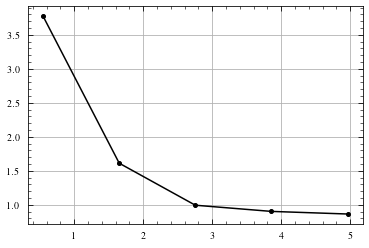

In [56]:
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
# annuli_area = (
#     np.array([annulus.area for annulus in vcc792_annuli])
#     # * pc_per_px[0].value / 1000
#     # * pc_per_px[1].value / 1000
# )
# avg_co = vcc792_sum_data / annuli_area
# avg_co_err = vcc792_sum_noise / annuli_area
# print(avg_co)
# print(avg_co_err)
#
fig, ax = plt.subplots()
ebar = ax.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    # yerr=avg_co_err / (avg_co * np.log(10)),
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
# ax.semilogy()
# ebar[-1][0].set_linestyle("--")
# ax.set_ylim(bottom=0)
plt.show()

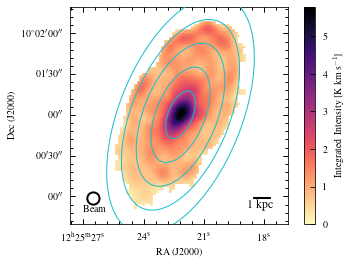

In [43]:
fig, ax = plt.subplots(subplot_kw={"projection": wcs_co})
data_co_masked = np.ma.masked_where(data_co <= 0, data_co).filled(np.nan)
# img = ax.contourf(data_co_masked, cmap="magma_r", levels=22)
img = ax.imshow(data_co_masked, cmap="magma_r", vmin=0)
cbar = fig.colorbar(img)
cbar.ax.minorticks_off()
cbar.set_label(r"Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
xbeam, ybeam = 8, 9
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    angle=(co_beam_pa - 90) % 360.0,
    ls="-", edgecolor="k", fc='None', lw=2, zorder=2
)
ax.add_patch(ellipse)
xtxt, ytxt = (xbeam - 4, ybeam - 5)
ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc")
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()

Saved imgs/vcc792_rad_prof_Kkms_9as_mean.pdf


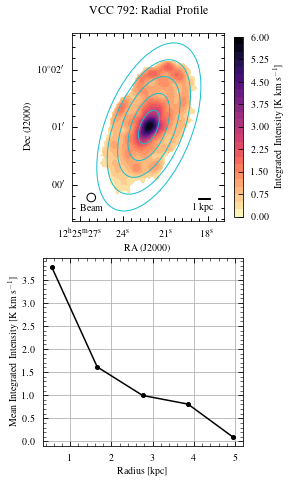

In [74]:
%matplotlib inline
plt.close("all")
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=wcs_co)
data_co_masked = np.ma.masked_where(data_co <= 0, data_co).filled(np.nan)
img = ax.contourf(data_co_masked, cmap="magma_r", levels=22)
# img = ax.imshow(data_co_masked, cmap="magma_r", vmin=0)
cbar = fig.colorbar(img, fraction=0.045)
cbar.ax.minorticks_off()
cbar.set_label(r"Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
ax.set_ylim(-9, data_co.shape[0] + 9)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
# xbeam, ybeam = 10, 11
xbeam, ybeam = 10, 3
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
    angle=(co_beam_pa - 90) % 360.0,
    ls="-", edgecolor="k", fc='None', lw=1, zorder=2
)
ax.add_patch(ellipse)
# xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
xtxt, ytxt = (xbeam - 6, ybeam - 7)
ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc",
                   fontsize=10, pad=0.75, sep=4)
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
#
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    yerr=vcc792_avg_noise,
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
# ax2.semilogy()
# ax2.set_ylim(bottom=1)
# ax2.grid(False)
ax2.set_xlabel("Radius [kpc]")
# ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
ax2.set_ylabel(f"{vcc792_co_func.capitalize()} Integrated Intensity [$\\rm K\\; km\\; s^{{-1}}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
# fig.savefig(f"imgs/vcc792_rad_prof_Kkms_{co_type}_{vcc792_co_func}.pdf")
# print("Saved", f"imgs/vcc792_rad_prof_Kkms_{co_type}_{vcc792_co_func}.pdf")
plt.show()

### Differences between mean and median


In [67]:
(
    mean_gas,
    mean_gas_err,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    data_co,
    header_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=unc_co_noDistErr,
    # noise=None,
    n_annuli=5,
    wcs=wcs_co,
    include_bad=True,
    func="mean",
)
(
    median_gas,
    median_gas_err,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    data_co,
    header_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=unc_co_noDistErr,
    # noise=None,
    n_annuli=5,
    wcs=wcs_co,
    include_bad=True,
    func="median",
)

Min width (pixels): 4.50000000014364
Min width (pixels): 4.50000000014364


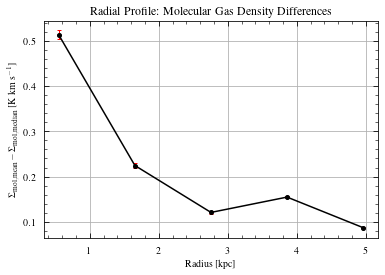

In [70]:
pc_per_px = utils.calc_pixel_size(wcs_co, dist=vcc792_dist)[0]
vcc792_radii_kpc = vcc792_radii * pc_per_px[0] / 1000
gas_diffs = mean_gas - median_gas
gas_diffs_err = np.sqrt(mean_gas_err ** 2 + median_gas_err ** 2)
# 
fig, ax = plt.subplots()
ebar = ax.errorbar(
    x=vcc792_radii_kpc,
    y=gas_diffs,
    yerr=gas_diffs_err,
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
ax.set_xlabel("Radius [kpc]")
ax.set_ylabel(r"$\rm \Sigma_{mol, mean} - \Sigma_{mol, median}$ [$\rm K\; km\; s^{-1}$]")
ax.set_title("Radial Profile: Molecular Gas Density Differences")
fig.savefig("imgs/vcc792_rad_prof_Kkms_9as_diffs.pdf")
plt.show()

# Radial profiles of NGVS data


## 9 arcsec beam, 2 arcsec pixel NGVS binned data


In [57]:
MLi_data_path = "/arc/home/IsaacCheng/coop_f2021/binned_data/vcc792_MLi_BINNED_reproject_interp+masked_star2_9as.txt"
MLi_data = pd.read_csv(MLi_data_path, sep=" ")
MLi_coords = MLi_data["id"].values.reshape(80, 80)  # correct. No transpose needed
MLi_density = MLi_data["M_density"].values.reshape(80, 80)
MLi_density_err = MLi_data["M_density_err"].values.reshape(80, 80)
# 
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
# Load CO map data
#
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# print(wcs_co.pixel_to_world(data_co.shape[0]//2, data_co.shape[1]//2))  # approx center
# print(header_co)
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
# vcc792_centre = coord.SkyCoord("12 25 22.16 +10 01 00.12", unit=(u.hourangle, u.deg), frame=header_co["RADESYS"].lower())
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   
USING 9as Kkms-1 CO DATA


In [58]:
MLi_density_masked = np.ma.masked_where(data_co <= 0, MLi_density).filled(np.nan)
MLi_density_err_masked = np.ma.masked_where(data_co <= 0, MLi_density_err).filled(np.nan)
(
    vcc792_avg_data,
    vcc792_avg_noise,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    MLi_density_masked,
    header_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=MLi_density_err_masked,
    # noise=None,
    n_annuli=5,
    wcs=wcs_co,
    include_bad=True,
    func="median",
)

/tmp/ipykernel_4787/2414886185.py:63: RuntimeWarning: invalid value encountered in true_divide
  yerr=vcc792_avg_noise / (vcc792_avg_data * np.log(10)),


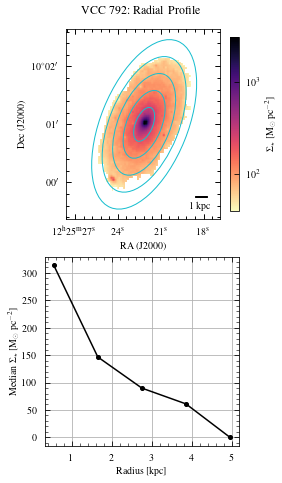

In [62]:
%matplotlib inline
plt.close("all")
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=wcs_co)
MLi_density_masked = np.ma.masked_where(data_co <= 0, MLi_density).filled(np.nan)
# MLi_density_masked = MLi_density
# img = ax.contourf(MLi_density_masked, cmap="magma_r", locator=mpl.ticker.LogLocator(),)
# img = ax.contourf(MLi_density_masked, cmap="magma_r", norm=mpl.colors.LogNorm(),
#                   levels=np.linspace(np.nanmin(MLi_density_masked), np.nanmax(MLi_density_masked), 10))
img = ax.imshow(MLi_density_masked, cmap="magma_r", norm=mpl.colors.LogNorm())
cbar = fig.colorbar(img, fraction=0.045)
cbar.ax.minorticks_off()
cbar.set_label(r"$\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
ax.set_ylim(-9, data_co.shape[0] + 9)
# # Add beam size
# co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
# # xbeam, ybeam = 10, 11
# xbeam, ybeam = 10, 3
# ellipse = Ellipse(
#     xy=(xbeam, ybeam),
#     width=co_beam_minor,
#     height=co_beam_major,
#     # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
#     angle=(co_beam_pa - 90) % 360.0,
#     ls="-", edgecolor="k", fc='None', lw=1, zorder=2
# )
# ax.add_patch(ellipse)
# # xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
# xtxt, ytxt = (xbeam - 6, ybeam - 7)
# ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc",
                   fontsize=10, pad=0.75, sep=4)
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
#
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    yerr=vcc792_avg_noise / (vcc792_avg_data * np.log(10)),
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
# ax2.semilogy()
# ax2.grid(False)
ax2.set_xlabel("Radius [kpc]")
# ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
ax2.set_ylabel(r"Median $\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
# fig.savefig("imgs/vcc792_rad_prof_MLi_yesMask.pdf")
plt.show()

## Voronoi binned NGVS data


In [101]:
# 
# Load NGVS data
# 
# Signal
zband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits"
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# # Noise (sigma maps)
# znoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.sig.3136_8588_6905_10184.fits"
# inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
# gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
# unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# # Mask (flap maps)
# zgood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.flag.3136_8588_6905_10184.fits"
# igood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.flag.3136_8588_6905_10184.fits"
# ggood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.flag.3136_8588_6905_10184.fits"
# ugood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.flag.3136_8588_6905_10184.fits"
# Signal
data_z, header_z = utils.load_img(zband_path)
data_i, header_i = utils.load_img(iband_path)
data_g, header_g = utils.load_img(gband_path)
data_u, header_u = utils.load_img(uband_path)
# # Noise
# noise_z, header_noise_z = utils.load_img(znoise_path)
# noise_i, header_noise_i = utils.load_img(inoise_path)
# noise_g, header_noise_g = utils.load_img(gnoise_path)
# noise_u, header_noise_u = utils.load_img(unoise_path)
# # Masks
# good_z, header_good_z = utils.load_img(zgood_path, idx=1)
# good_i, header_good_i = utils.load_img(igood_path, idx=1)
# good_g, header_good_g = utils.load_img(ggood_path, idx=1)
# good_u, header_good_u = utils.load_img(ugood_path, idx=1)
# 
# Load CO map data (ONLY FOR creating SkyCoord of VCC 792's centre)
#
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster
# 
header_lst = [header_z, header_i, header_g, header_u]
ngvs_min_width_idx = np.max([ngvs_header["IQMAX"] for ngvs_header in header_lst])
ngvs_min_width_idx = np.argmax([ngvs_header["IQMAX"] for ngvs_header in header_lst])
ngvs_min_width_header = header_lst[ngvs_min_width_idx]
ngvs_min_width_arcsec = ngvs_min_width_header["IQMAX"] * u.arcsec
print("Worst NGVS image quality (arcsec):", ngvs_min_width_arcsec)
print("Band corresponding to worst NGVS image quality:", ["z", "i", "g", "u"][ngvs_min_width_idx])
# 
# Load stellar mass data
# 
MLi_data_path = "/arc/home/IsaacCheng/coop_f2021/binned_data/vcc792_MLi_allVorBinned_snr30.pkl"
with open(MLi_data_path, "rb") as f:
    MLi_data = dill.load(f)
MLi_density = MLi_data["M_density"]
MLi_density_err = MLi_data["M_density_err_noDistErr"]
# 
vorbin_data_path = "/arc/home/IsaacCheng/coop_f2021/warmup/vcc792_allVorBinned_snr30.pkl"
with open(vorbin_data_path, "rb") as f:
    vorbin_data = dill.load(f)
ngvs_wcs = vorbin_data["wcs"]

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co

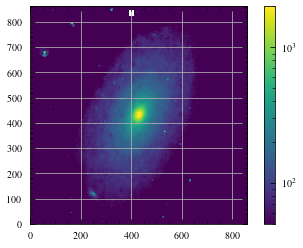

In [42]:
fig, ax = plt.subplots()
img = ax.imshow(MLi_density, origin="lower", norm=mpl.colors.LogNorm(vmin=50, vmax=2000))
cbar = fig.colorbar(img, ax=ax)
plt.show()

In [105]:
vcc792_vorbin_func = "median"
(
    vcc792_avg_data,
    vcc792_avg_noise,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = optical_radial_profile(
    MLi_density,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=MLi_density_err,
    # noise=None,
    n_annuli=40,
    header=ngvs_min_width_header,
    wcs=ngvs_wcs,
    include_bad=True,
    func=vcc792_vorbin_func,
)

Info: using provided WCS instead of converting header to WCS
Min width (arcsec): 1.13 arcsec
Min width (pixels): 6.082039986066301


Saved: imgs/vcc792_rad_prof_MLi_vorbin_median.pdf


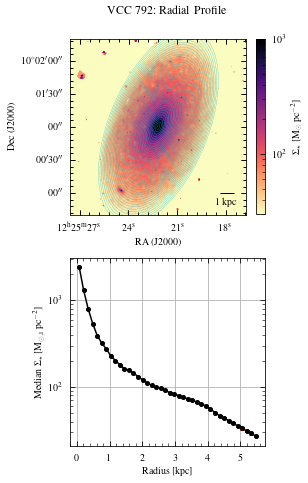

In [99]:
%matplotlib inline
plt.close("all")
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=ngvs_wcs)
# MLi_density_masked = MLi_density
# img = ax.contourf(MLi_density_masked, cmap="magma_r", locator=mpl.ticker.LogLocator(),)
# img = ax.contourf(MLi_density_masked, cmap="magma_r", norm=mpl.colors.LogNorm(),
#                   levels=np.linspace(np.nanmin(MLi_density_masked), np.nanmax(MLi_density_masked), 10))
img = ax.imshow(MLi_density, cmap="magma_r", norm=mpl.colors.LogNorm(vmin=30, vmax=1000))
cbar = fig.colorbar(img, fraction=0.045)
cbar.set_label(r"$\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=0.25, zorder=2
    )
    ax.add_patch(ellipse)
# # Add beam size
# co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
# # xbeam, ybeam = 10, 11
# xbeam, ybeam = 10, 3
# ellipse = Ellipse(
#     xy=(xbeam, ybeam),
#     width=co_beam_minor,
#     height=co_beam_major,
#     # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
#     angle=(co_beam_pa - 90) % 360.0,
#     ls="-", edgecolor="k", fc='None', lw=1, zorder=2
# )
# ax.add_patch(ellipse)
# # xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
# xtxt, ytxt = (xbeam - 6, ybeam - 7)
# ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, ngvs_wcs, vcc792_dist, scalebar_factor=1, label="1 kpc",
                   fontsize=10, pad=0.75, sep=4)
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
#
pc_per_px = utils.calc_pixel_size(ngvs_wcs, dist=vcc792_dist)[0]
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    yerr=vcc792_avg_noise,
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
ax2.semilogy()
# ax2.grid(False)
ax2.set_xlabel("Radius [kpc]")
# ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
ax2.set_ylabel(f"{vcc792_vorbin_func.capitalize()} $\\Sigma_\\star$ [$\\rm M_{{\\odot,i}}\\; pc^{{-2}}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
# fig.savefig(f"imgs/vcc792_rad_prof_MLi_vorbin_{vcc792_vorbin_func}.pdf")
# print("Saved:", f"imgs/vcc792_rad_prof_MLi_vorbin_{vcc792_vorbin_func}.pdf")
plt.show()

### Differences between mean and median


In [76]:
(
    MLi_mean_data,
    MLi_mean_data_err,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = optical_radial_profile(
    MLi_density,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=MLi_density_err,
    # noise=None,
    n_annuli=40,
    header=ngvs_min_width_header,
    wcs=ngvs_wcs,
    include_bad=True,
    func="mean",
)
(
    MLi_median_data,
    MLi_median_data_err,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = optical_radial_profile(
    MLi_density,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=MLi_density_err,
    # noise=None,
    n_annuli=40,
    header=ngvs_min_width_header,
    wcs=ngvs_wcs,
    include_bad=True,
    func="median",
)

Info: using provided WCS instead of converting header to WCS
Min width (arcsec): 1.13 arcsec
Min width (pixels): 6.082039986066301
Info: using provided WCS instead of converting header to WCS
Min width (arcsec): 1.13 arcsec
Min width (pixels): 6.082039986066301


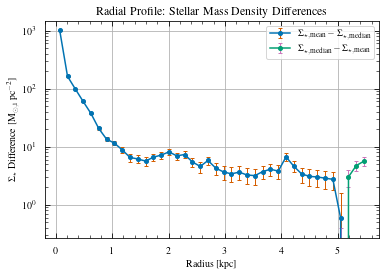

In [93]:
pc_per_px = utils.calc_pixel_size(ngvs_wcs, dist=vcc792_dist)[0]
vcc792_radii_kpc = vcc792_radii * pc_per_px[0] / 1000
MLi_diffs1 = MLi_mean_data - MLi_median_data
MLi_diffs2 = MLi_median_data - MLi_mean_data
MLi_diffs_err = np.sqrt(MLi_mean_data_err ** 2 + MLi_median_data_err ** 2)
# 
fig, ax = plt.subplots()
ebar1 = ax.errorbar(
    x=vcc792_radii_kpc,
    y=MLi_diffs1,
    yerr=MLi_diffs_err,
    fmt="-o",
    markersize=4,
    color=sns.color_palette("colorblind")[0],
    ecolor=sns.color_palette("colorblind")[3],
    elinewidth=1,
    capsize=2,
    label=r"$\rm \Sigma_{\star, mean} - \Sigma_{\star, median}$"
)
# ebar1[-1][0].set_linestyle("--")
ebar2 = ax.errorbar(
    x=vcc792_radii_kpc,
    y=MLi_diffs2,
    yerr=MLi_diffs_err,
    fmt="-o",
    markersize=4,
    color=sns.color_palette("colorblind")[2],
    ecolor=sns.color_palette("colorblind")[4],
    elinewidth=1,
    capsize=2,
    label=r"$\rm \Sigma_{\star, median} - \Sigma_{\star, mean}$"
)
# ebar2[-1][0].set_linestyle("--")
ax.set_xlabel("Radius [kpc]")
ax.set_ylabel(r"$\rm \Sigma_\star$ Difference [$\rm M_{\odot,i}\; pc^{-2}$]")
ax.set_title("Radial Profile: Stellar Mass Density Differences")
ax.semilogy()
ax.legend()
# fig.savefig("imgs/vcc792_rad_prof_MLi_vorbin_diffs.pdf")
plt.show()